
<center><h1>Implementación Attention is All You Need.ipynb</h1> </center>


<center>
<p><a href="https://arxiv.org/abs/1706.03762">Attention is All You Need
</a></p>
</center>

<center>

**Allan Murillo Gonzalez**

**Brian Morera Madriz**

**Esteban Esquivel Barboza**

**Froilan Moya Robles**

**Michael Pérez Ocampo**<br><br>

**23 de Nomviembre del 2023**<br><br>

**Instituto Tecnológico de Costa Rica**

**Maestría en Ciencias de la Computación**

</center>


# Preliminar

In [33]:
# Instalación de paquetes
# !pip install -r requirements.txt

In [38]:
####### Descomentar para Colab
# !pip install -q torchdata==0.3.0 torchtext==0.12 spacy==3.2 altair GPUtil
# !python -m spacy download de_core_news_sm
# !python -m spacy download en_core_web_sm

In [39]:
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import spacy
import GPUtil
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP

# Establecer a False para omitir la ejecución del notebook (e.g. debugging)
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

In [40]:
def is_interactive_notebook():
    return __name__ == "__main__"


def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)


def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)


class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None


class DummyScheduler:
    def step(self):
        None

# Background

El actual proyecto tiene como objetivo proveer una implementación pedagógica de una versión simplificada del modelo `Transformer` del artículo `Attention Is All You Need`. En el mismo se encuentra definiciones y conceptos que ayudarán a comprender la implementación presentada.

# Parte 1: Arquitectura del modelo

# Arquitectura del modelo

En el estado del arte actual, la mayoría de modelos de traducción utilizan una estructura de encoder-decoder. La idea de estos modelos es tomar una entrada con la forma $(x_1, ..., x_n)$ y traducirla a una representación intermedia $\mathbf{z} = (z_1, ...,
z_n)$ utilizando un encoder. Luego, dado $\mathbf{z}$, el decoder genera una salida $(y_1,...,y_m)$.

![EncoderDecoder](https://jalammar.github.io/images/t/The_transformer_encoders_decoders.png)

Otro detalle es que el modelo es "auto regresivo", esto quiere decir que para generar un símbolo se utiliza el símbolo anterior como entrada adicional. Esto lo hacen utilizando varias capas de encoders y de decoders.

![](https://jalammar.github.io/images/t/The_transformer_encoder_decoder_stack.png)



In [41]:
class EncoderDecoder(nn.Module):
    """
    Base de cualquier modelo Encoder - Decoder. 
    Recibe un modelo que sirve como encoder, un modelo decoder.
    Además toma una función para generar embeddings.
    También recibe una función que se va a utilizar para generar salidas
    """

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        """Toma una entrada, una salida y las mascaras de ambos. Encodea la entrada y la utiliza como memoria (auto regresión)."""
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [42]:
class Generator(nn.Module):
    "Un generador muy básico que utiliza uan capa linear y una capa softmax."

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return log_softmax(self.proj(x), dim=-1)

Recuerde que el transformer utiliza esta arquitectura, apilando capas de self-attention (auto atención) y dot-product attention (atención producto punto).

![](images/ModalNet-21.png)

## Pilas de Encoder and Decoder

### Pilas del Encoder

El encoder está compuesto por una pila de $N=6$ capas iguales.

In [43]:
def clones(module, N):
    "Clona un modulo N veces."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

En el paper (sección 3.1) se utiliza una capa de normalización llamada "layer normalization" (normalización de capa).
No hay que hondar mucho en esto, puesto que es una decisión que se puede cambiar por otro tipo de normalización.

In [46]:
class LayerNorm(nn.Module):
    "Se construye una capa de normalización de capa"

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [47]:
class Encoder(nn.Module):
    "Un encoder de N capas y una capa de normalización"

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Se pasa cada entrada con su mascara por cada capa y luego se normaliza."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


El paper explica que cada salida de una capa de encoding es $\mathrm{LayerNorm}(x +
\mathrm{Sublayer}(x))$, donde $\mathrm{Sublayer}(x)$ es la función implementada por la sub capa como tal. Y como se indica en la sección 5 de regularización, se utiliza al técnica de de dropout entre cada capa. Esto nos sirve para mejorar la generalización del modelo.
Esto se puede observar en la siguiente figura, en la parte izquierda marcada como "The encoder".
![](https://miro.medium.com/v2/resize:fit:863/0*jKqypwGzmDv7KDUZ.png)

In [48]:
class SublayerConnection(nn.Module):
    """
    Una conección residual seguida de una capa de normalización
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Se aplica la conección residual para cualquier subcapa del mismo tamaño."
        return x + self.dropout(sublayer(self.norm(x)))

Cada capa del encoder tiene dos sub capas: la primera es una capa de self-attention y la segunda es una capa totalmente conectada (fully connected o feed forward).

![](https://jalammar.github.io/images/t/Transformer_encoder.png)

In [49]:
class EncoderLayer(nn.Module):
    "Encoder compuesto de un self-attention y un feed forward"

    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Se toma una entrada y su mascara, se pasa por la capa de self attention y luego por el feed forward"
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

### Decoder

El decoder, al igual que el encoder, está compuesto por una pila de $N=6$ capas iguales.


In [50]:
class Decoder(nn.Module):
    "Decoder con N capas."

    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

El decoder, además de las dos subcapas que utiliza el encoder utiliza una tercera, la cual utiliza el multi-head attention junto a la salida de la pila de encoders. 

Por lo tanto serían tres capas:
- Capa de self attention con la salida esperada (utilizando mascaras).
- Capa de attention del decoder junto a la salida del decoder.
- Capa fully connected.

Igual que el enconder, se utilizan las conecciones residuales y la normalización de capa.

In [51]:
class DecoderLayer(nn.Module):
    "Decoder compuesto por el self attention, la atención con el encoder y el feed forward"

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

Como se explicó anterior, ocupamos modificar el self-attetion para enmascarar posiciones para evitar atención con posiciones subsecuentes, en otras palabras, que el token actual no tenga atención con un token "del futuro". Por lo tanto las predicciones para una posición $i$ solo puede depender de posiciones anteriores (menores que $i$).

In [52]:
def subsequent_mask(size):
    "Enmascara posiciones subsecuentes."
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(
        torch.uint8
    )
    return subsequent_mask == 0

## Self-Attention

Cuando se lee e interpreta un texto, una misma palabra puede comprenderse de distintas maneras, donde cada una de estas depende del contexto o conjunto de otras palabras que se encuentran alrededor de esta. Dado el siguiente texto de ejemplo, surge la pregunta de cómo debe interpretarse la palabra `it`, remitiéndonos a la gramática, la palabra `it` puede referirse a cualquier objeto, sin embargo en el contexto de la frase debe relacionarse al animal que no cruzó la calle.

`"The animal didn't cross the street because it was too tired"`

Self-attention es el método que utiliza el Transformer para relacionar la importancia de la palabra que está siendo procesada, con respecto a las otras palabras que son parte de la oración. En el actual ejemplo, la siguiente imagen mustra la relación de la palabra `it` para con las otras y su grado de relevancia (intensidad de color); así, se puede determinar que `it` tiene una gran relación con ella misma y con la palabra `animal`:

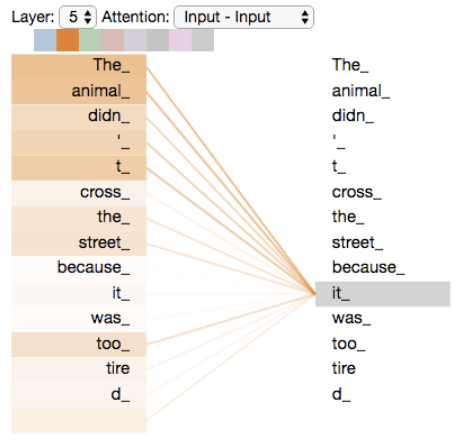

La atención puede comprenderse como un mapeo entre tres (3) vectores, estos vectores son `query`, `key` (ambos de tamaño $d_k$) y `value` (de tamaño $d_v$).  Así, la salida se calcula como una suma ponderada de los valores, donde el peso asignado a cada valor (`value`) se calcula mediante una función de compatibilidad entre la consulta (`query`) y la clave (`key`) correspondiente. El artículo <a href="https://arxiv.org/abs/1706.03762">Attention is All You Need</a> llama `Scaled Dot-Product Attention` a las siguientes operaciones con los vectores mencionados, tal como se muestra en la figura:

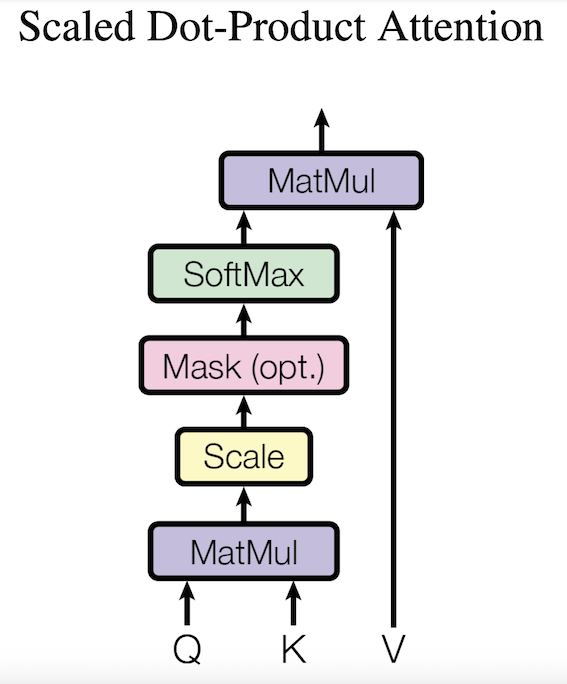

Sin embargo, las implementaciones se realizan de manera matricial, de tal manera que los vectores de `query` se empaquetan en una matriz llamada $Q$, los vectores de `key` en la matriz $K$ y los vectores de `value` en la matriz $V$; En el primer paso, se calcula la similitud entre $Q$ y $K$ multiplicando las matrices; en el segundo paso, se escala la salida dividiéndola por la raíz cuadrada de $d_k$. En el tercer paso, se puede aplicar una máscara (opcionalmente); luego, se normalizan las similitudes mediante la función softmax para obtener la matriz de atención $A$, tal como se muestra en la siguiente fórmula:

$$
\mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$
Finalmente, se realiza otra multiplicación de matrices entre $A$ y $V$.




In [53]:
def attention(query, key, value, mask=None, dropout=None):
    "Calcula 'Scaled Dot Product Attention' de manera matricial"
    d_k = query.size(-1)
    #1. Calcular los puntajes de atención del producto punto.
    #2. Escalar la salida dividiendo por la raíz cuadrada de d_k.
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    # 3 se enmascara (opcional)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)    
    # 3 Aplicar softmax para obtener los pesos de atención
    p_attn = scores.softmax(dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    # 5 Calcular la suma ponderada utilizando los pesos de atención
    return torch.matmul(p_attn, value), p_attn


`Multi-head attention` es el mecanismo que permite el modelo procese de manera conjunta o en paralelo información de diferentes subespacios de representación en diferentes posiciones, debido a esto el modelo puede centrarse en diferentes posiciones. Su definición es la siguiente:

$$
\mathrm{MultiHead}(Q, K, V) =
    \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O \\
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)
$$

Donde las proyecciones son matrices de parámetros $W^Q_i \in
\mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in
\mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in
\mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in
\mathbb{R}^{hd_v \times d_{\text{model}}}$.

La actual implementación emplea $h=8$ capas de atención paralelas o `heads`. Para cada una de estas se utiliza $d_k=d_v=d_{\text{model}}/h=64$. 
Debido a la reducción de la dimensión de cada cabeza, el costo computacional total es similar al de la atención de una sola cabeza con plena dimensionalidad.

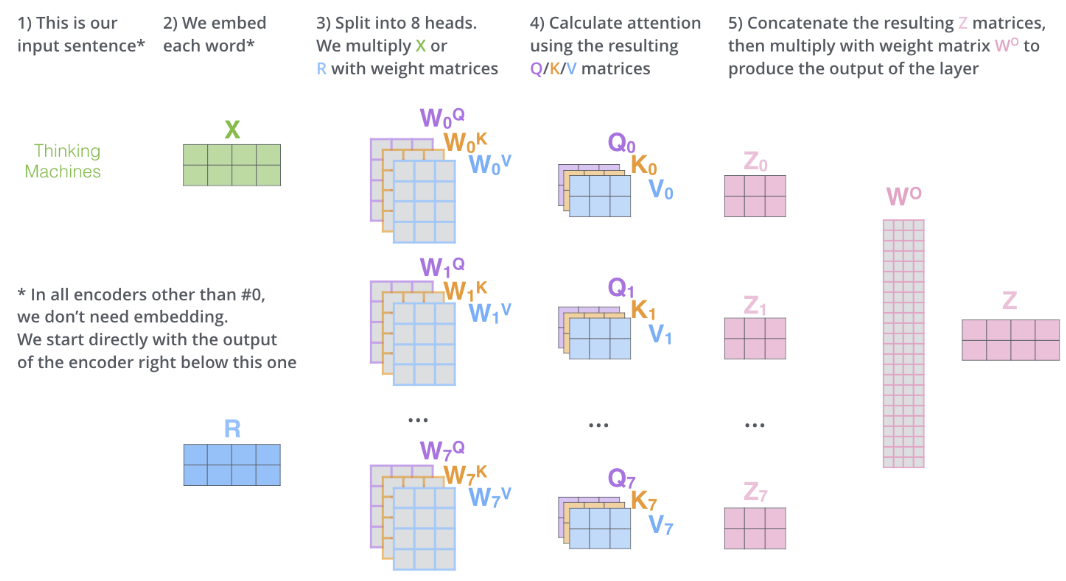

In [54]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Inicializa el tamaño del modelo y números de heads"
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # Siempre se asume d_v = d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Se aplica la misma máscara para todos los heads
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Realiza todas las proyecciones lineales en lote desde d_model => h x d_k.
        query, key, value = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]

        # 2) Aplica atención a todos los vectores proyectados en lote.
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )

        # 3) "Hace un 'concat' utilizando una vista y aplica una lineal final."
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(nbatches, -1, self.h * self.d_k)
        )
        del query
        del key
        del value
        return self.linears[-1](x)

## Position-wise Feed-Forward Networks

Además de las subcapas de atención, cada capa en ell codificador y decodificador contiene una red de retroalimentación totalmente conectada, que se aplica a cada posición de manera separada e idéntica. Esto consiste en dos transformaciones lineales con una activación `ReLU`` en medio.

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$

Aunque las transformaciones lineales son las mismas para cada capa, estas utilizan parámetros diferentes entre capas. Otra forma de describir esto es como dos convoluciones con tamaño de núcleo 1. La dimensionalidad de la entrada y la salida es $d_{\text{model}}=512$, y la capa interna tiene una dimensionalidad de $d_{ff}=2048$.

In [55]:
class PositionwiseFeedForward(nn.Module):
    "Implementa la ecuación FFN."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))

## Embeddings y Softmax

Se utiliza `embeddings` para convertir los tokens de entrada y los tokens de salida en vectores de dimensión $d_{\text{model}}$. También, se hace uso de la transformación lineal aprendida y la función `softmax` para convertir la salida del decodificador en probabilidades que se utilizarán en el siguiente token. En las capas de `embeddings` se multiplican los pesos por $\sqrt{d_{\text{model}}}$.

In [56]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## Positional Encoding

Las codificaciones posicionales se utilizan en modelos de secuencia a secuencia, particularmente en arquitecturas de Transformer, para proporcionar información posicional al modelo. En los Transformers, no hay nociones inherentes del orden o la posición de los tokens dentro de una secuencia, por lo que se añaden codificaciones posicionales a las incrustaciones de entrada para brindar al modelo información sobre las posiciones de los tokens en la secuencia.

Existen diferentes maneras de implementar codificaciones posicionales, pero un método común introducido en el modelo Transformer es el uso de funciones seno y coseno de diferentes frecuencias a lo largo de las posiciones. Estas codificaciones posicionales se suman a las incrustaciones de entrada de los tokens

En este trabajo, utilizamos funciones seno y coseno de diferentes frecuencias:

$$PE_{(pos,2i)} = \sin(pos / 10000^{2i/d_{\text{model}}})$$

$$PE_{(pos,2i+1)} = \cos(pos / 10000^{2i/d_{\text{model}}})$$

Donde $pos$ es la posición e $i$ es la dimensión. Es decir, cada dimensión de la codificación posicional corresponde a un sinusoid. Las longitudes de onda forman una progresión geométrica desde $2\pi$ hasta $10000 \cdot 2\pi$. Elegimos esta función porque hipotetizamos que permitiría al modelo aprender fácilmente a atender a posiciones relativas, ya que para cualquier desplazamiento fijo $k$, $PE_{pos+k}$ puede representarse como una función lineal de $PE_{pos}

Además, aplicamos dropout a las sumas de las incrustaciones y las codificaciones posicionales tanto en las pilas del codificador como del decodificador. Para el modelo base, utilizamos una tasa de $P_{drop}=0.1$



In [57]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)


> Below the positional encoding will add in a sine wave based on
> position. The frequency and offset of the wave is different for
> each dimension.

In [58]:
def example_positional():
    pe = PositionalEncoding(20, 0)
    y = pe.forward(torch.zeros(1, 100, 20))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[0, :, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )


show_example(example_positional)

alt.Chart(...)

## Full Model

> Here we define a function from hyperparameters to a full model.

In [59]:
def make_model(
    src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1
):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab),
    )

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

## Inference:

> Here we make a forward step to generate a prediction of the
model. We try to use our transformer to memorize the input. As you
will see the output is randomly generated due to the fact that the
model is not trained yet. In the next tutorial we will build the
training function and try to train our model to memorize the numbers
from 1 to 10.

In [60]:
def inference_test():
    test_model = make_model(11, 11, 2)
    test_model.eval()
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    memory = test_model.encode(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src)

    for i in range(9):
        out = test_model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = test_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    print("Example Untrained Model Prediction:", ys)


def run_tests():
    for _ in range(10):
        inference_test()


show_example(run_tests)

Example Untrained Model Prediction: tensor([[0, 8, 5, 9, 5, 9, 5, 9, 5, 9]])
Example Untrained Model Prediction: tensor([[0, 8, 6, 8, 6, 8, 6, 8, 6, 8]])
Example Untrained Model Prediction: tensor([[ 0,  8,  5, 10,  9, 10,  9,  9,  9, 10]])
Example Untrained Model Prediction: tensor([[ 0, 10,  3, 10,  3, 10,  4,  6, 10,  4]])
Example Untrained Model Prediction: tensor([[0, 3, 3, 3, 3, 3, 3, 3, 3, 3]])
Example Untrained Model Prediction: tensor([[0, 1, 5, 8, 1, 5, 8, 1, 5, 8]])
Example Untrained Model Prediction: tensor([[ 0,  7,  4,  8, 10,  9,  0,  6,  4,  8]])
Example Untrained Model Prediction: tensor([[0, 8, 1, 8, 1, 8, 1, 8, 1, 8]])
Example Untrained Model Prediction: tensor([[0, 6, 9, 8, 9, 8, 9, 8, 9, 8]])
Example Untrained Model Prediction: tensor([[0, 4, 4, 9, 0, 4, 9, 0, 4, 0]])


# Part 2: Model Training

# Training

This section describes the training regime for our models.


> We stop for a quick interlude to introduce some of the tools
> needed to train a standard encoder decoder model. First we define a
> batch object that holds the src and target sentences for training,
> as well as constructing the masks.

## Batches and Masking

In [61]:
class Batch:
    """Object for holding a batch of data with mask during training."""

    def __init__(self, src, tgt=None, pad=2):  # 2 = <blank>
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(
            tgt_mask.data
        )
        return tgt_mask


> Next we create a generic training and scoring function to keep
> track of loss. We pass in a generic loss compute function that
> also handles parameter updates.

## Training Loop

In [62]:
class TrainState:
    """Track number of steps, examples, and tokens processed"""

    step: int = 0  # Steps in the current epoch
    accum_step: int = 0  # Number of gradient accumulation steps
    samples: int = 0  # total # of examples used
    tokens: int = 0  # total # of tokens processed

In [63]:
def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,
    train_state=TrainState(),
):
    """Train a single epoch"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        # loss_node = loss_node / accum_iter
        if mode == "train" or mode == "train+log":
            loss_node.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens
            if i % accum_iter == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        del loss
        del loss_node
    return total_loss / total_tokens, train_state

## Training Data and Batching

We trained on the standard WMT 2014 English-German dataset
consisting of about 4.5 million sentence pairs.  Sentences were
encoded using byte-pair encoding, which has a shared source-target
vocabulary of about 37000 tokens. For English-French, we used the
significantly larger WMT 2014 English-French dataset consisting of
36M sentences and split tokens into a 32000 word-piece vocabulary.


Sentence pairs were batched together by approximate sequence length.
Each training batch contained a set of sentence pairs containing
approximately 25000 source tokens and 25000 target tokens.

## Hardware and Schedule

We trained our models on one machine with 8 NVIDIA P100 GPUs.  For
our base models using the hyperparameters described throughout the
paper, each training step took about 0.4 seconds.  We trained the
base models for a total of 100,000 steps or 12 hours. For our big
models, step time was 1.0 seconds.  The big models were trained for
300,000 steps (3.5 days).

## Optimizer

We used the Adam optimizer [(cite)](https://arxiv.org/abs/1412.6980)
with $\beta_1=0.9$, $\beta_2=0.98$ and $\epsilon=10^{-9}$.  We
varied the learning rate over the course of training, according to
the formula:

$$
lrate = d_{\text{model}}^{-0.5} \cdot
  \min({step\_num}^{-0.5},
    {step\_num} \cdot {warmup\_steps}^{-1.5})
$$

This corresponds to increasing the learning rate linearly for the
first $warmup\_steps$ training steps, and decreasing it thereafter
proportionally to the inverse square root of the step number.  We
used $warmup\_steps=4000$.


> Note: This part is very important. Need to train with this setup
> of the model.


> Example of the curves of this model for different model sizes and
> for optimization hyperparameters.

In [64]:
def rate(step, model_size, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

In [65]:
def example_learning_schedule():
    opts = [
        [512, 1, 4000],  # example 1
        [512, 1, 8000],  # example 2
        [256, 1, 4000],  # example 3
    ]

    dummy_model = torch.nn.Linear(1, 1)
    learning_rates = []

    # we have 3 examples in opts list.
    for idx, example in enumerate(opts):
        # run 20000 epoch for each example
        optimizer = torch.optim.Adam(
            dummy_model.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9
        )
        lr_scheduler = LambdaLR(
            optimizer=optimizer, lr_lambda=lambda step: rate(step, *example)
        )
        tmp = []
        # take 20K dummy training steps, save the learning rate at each step
        for step in range(20000):
            tmp.append(optimizer.param_groups[0]["lr"])
            optimizer.step()
            lr_scheduler.step()
        learning_rates.append(tmp)

    learning_rates = torch.tensor(learning_rates)

    # Enable altair to handle more than 5000 rows
    alt.data_transformers.disable_max_rows()

    opts_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Learning Rate": learning_rates[warmup_idx, :],
                    "model_size:warmup": ["512:4000", "512:8000", "256:4000"][
                        warmup_idx
                    ],
                    "step": range(20000),
                }
            )
            for warmup_idx in [0, 1, 2]
        ]
    )

    return (
        alt.Chart(opts_data)
        .mark_line()
        .properties(width=600)
        .encode(x="step", y="Learning Rate", color="model_size:warmup:N")
        .interactive()
    )


example_learning_schedule()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/allanjs88/Documents/src/transformer/env/lib/python3.11/site-packages/altair/vegalite/v5/api.py", line 2310, in _repr_mimebundle_
    dct = self.to_dict(context={"pre_transform": False})
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/allanjs88/Documents/src/transformer/env/lib/python3.11/site-packages/altair/vegalite/v5/api.py", line 2713, in to_dict
    return super().to_dict(
           ^^^^^^^^^^^^^^^^
  File "/Users/allanjs88/Documents/src/transformer/env/lib/python3.11/site-packages/altair/vegalite/v5/api.py", line 921, in to_dict
    vegalite_spec = super(TopLevelMixin, copy).to_dict(  # type: ignore[misc]
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/allanjs88/Documents/src/transformer/env/lib/python3.11/site-packages/altair/utils/schemapi.py", line 965, in to_dict
    result = _todict(
             ^^^^^^^^
  File "/Users/allanjs88/Documents/src/transformer/e

alt.Chart(...)

## Regularization

### Label Smoothing

During training, we employed label smoothing of value
$\epsilon_{ls}=0.1$ [(cite)](https://arxiv.org/abs/1512.00567).
This hurts perplexity, as the model learns to be more unsure, but
improves accuracy and BLEU score.


> We implement label smoothing using the KL div loss. Instead of
> using a one-hot target distribution, we create a distribution that
> has `confidence` of the correct word and the rest of the
> `smoothing` mass distributed throughout the vocabulary.

In [66]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."

    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction="sum")
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist.clone().detach())


> Here we can see an example of how the mass is distributed to the
> words based on confidence.

In [67]:
# Example of label smoothing.


def example_label_smoothing():
    crit = LabelSmoothing(5, 0, 0.4)
    predict = torch.FloatTensor(
        [
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
        ]
    )
    crit(x=predict.log(), target=torch.LongTensor([2, 1, 0, 3, 3]))
    LS_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "target distribution": crit.true_dist[x, y].flatten(),
                    "columns": y,
                    "rows": x,
                }
            )
            for y in range(5)
            for x in range(5)
        ]
    )

    return (
        alt.Chart(LS_data)
        .mark_rect(color="Blue", opacity=1)
        .properties(height=200, width=200)
        .encode(
            alt.X("columns:O", title=None),
            alt.Y("rows:O", title=None),
            alt.Color(
                "target distribution:Q", scale=alt.Scale(scheme="viridis")
            ),
        )
        .interactive()
    )


show_example(example_label_smoothing)

alt.Chart(...)


> Label smoothing actually starts to penalize the model if it gets
> very confident about a given choice.

In [68]:


def loss(x, crit):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
    return crit(predict.log(), torch.LongTensor([1])).data


def penalization_visualization():
    crit = LabelSmoothing(5, 0, 0.1)
    loss_data = pd.DataFrame(
        {
            "Loss": [loss(x, crit) for x in range(1, 100)],
            "Steps": list(range(99)),
        }
    ).astype("float")

    return (
        alt.Chart(loss_data)
        .mark_line()
        .properties(width=350)
        .encode(
            x="Steps",
            y="Loss",
        )
        .interactive()
    )


show_example(penalization_visualization)

alt.Chart(...)

# A First  Example

> We can begin by trying out a simple copy-task. Given a random set
> of input symbols from a small vocabulary, the goal is to generate
> back those same symbols.

## Synthetic Data

In [69]:
def data_gen(V, batch_size, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.randint(1, V, size=(batch_size, 10))
        data[:, 0] = 1
        src = data.requires_grad_(False).clone().detach()
        tgt = data.requires_grad_(False).clone().detach()
        yield Batch(src, tgt, 0)

## Loss Computation

In [70]:
class SimpleLossCompute:
    "A simple loss compute and train function."

    def __init__(self, generator, criterion):
        self.generator = generator
        self.criterion = criterion

    def __call__(self, x, y, norm):
        x = self.generator(x)
        sloss = (
            self.criterion(
                x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)
            )
            / norm
        )
        return sloss.data * norm, sloss

## Greedy Decoding

> This code predicts a translation using greedy decoding for simplicity.

In [71]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len - 1):
        out = model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.zeros(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )
    return ys

In [72]:
# Train the simple copy task.


def example_simple_model():
    V = 11
    criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
    model = make_model(V, V, N=2)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, model_size=model.src_embed[0].d_model, factor=1.0, warmup=400
        ),
    )

    batch_size = 80
    for epoch in range(20):
        model.train()
        run_epoch(
            data_gen(V, batch_size, 20),
            model,
            SimpleLossCompute(model.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train",
        )
        model.eval()
        run_epoch(
            data_gen(V, batch_size, 5),
            model,
            SimpleLossCompute(model.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )[0]

    model.eval()
    src = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
    max_len = src.shape[1]
    src_mask = torch.ones(1, 1, max_len)
    print(greedy_decode(model, src, src_mask, max_len=max_len, start_symbol=0))


# execute_example(example_simple_model)

# Part 3: A Real World Example

> Now we consider a real-world example using the Multi30k
> German-English Translation task. This task is much smaller than
> the WMT task considered in the paper, but it illustrates the whole
> system. We also show how to use multi-gpu processing to make it
> really fast.

## Data Loading

> We will load the dataset using torchtext and spacy for
> tokenization.

In [73]:
# Load spacy tokenizer models, download them if they haven't been
# downloaded already


def load_tokenizers():

    try:
        spacy_de = spacy.load("de_core_news_sm")
    except IOError:
        os.system("python -m spacy download de_core_news_sm")
        spacy_de = spacy.load("de_core_news_sm")

    try:
        spacy_en = spacy.load("en_core_web_sm")
    except IOError:
        os.system("python -m spacy download en_core_web_sm")
        spacy_en = spacy.load("en_core_web_sm")

    return spacy_de, spacy_en

In [74]:
def tokenize(text, tokenizer):
    return [tok.text for tok in tokenizer.tokenizer(text)]


def yield_tokens(data_iter, tokenizer, index):
    for from_to_tuple in data_iter:
        yield tokenizer(from_to_tuple[index])

In [77]:


def build_vocabulary(spacy_de, spacy_en):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    print("Building German Vocabulary ...")
    train, val, test = datasets.Multi30k(language_pair=("de", "en"))
    vocab_src = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_de, index=0),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    print("Building English Vocabulary ...")
    train, val, test = datasets.Multi30k(language_pair=("de", "en"))
    vocab_tgt = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_en, index=1),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    vocab_src.set_default_index(vocab_src["<unk>"])
    vocab_tgt.set_default_index(vocab_tgt["<unk>"])

    return vocab_src, vocab_tgt


def load_vocab(spacy_de, spacy_en):
    if not exists("vocab.pt"):
        vocab_src, vocab_tgt = build_vocabulary(spacy_de, spacy_en)
        torch.save((vocab_src, vocab_tgt), "vocab.pt")
    else:
        vocab_src, vocab_tgt = torch.load("vocab.pt")
    print("Finished.\nVocabulary sizes:")
    print(len(vocab_src))
    print(len(vocab_tgt))
    return vocab_src, vocab_tgt


if is_interactive_notebook():
    # global variables used later in the script
    spacy_de, spacy_en = show_example(load_tokenizers)
    vocab_src, vocab_tgt = show_example(load_vocab, args=[spacy_de, spacy_en])

Building German Vocabulary ...
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/allanjs88/Documents/src/transformer/env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
  File "/var/folders/hb/gp8cxt7x24s9p16zy2y2pnjc0000gn/T/ipykernel_25063/2393618745.py", line 45, in <module>
    vocab_src, vocab_tgt = show_example(load_vocab, args=[spacy_de, spacy_en])
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/hb/gp8cxt7x24s9p16zy2y2pnjc0000gn/T/ipykernel_25063/1650619497.py", line 7, in show_example
    return fn(*args)
           ^^^^^^^^^
  File "/var/folders/hb/gp8cxt7x24s9p16zy2y2pnjc0000gn/T/ipykernel_25063/2393618745.py", line 32, in load_vocab
    vocab_src, vocab_tgt = build_vocabulary(spacy_de, spacy_en)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/hb/gp8cxt7x24s9p16zy2y2pnjc0000gn/T/ipykernel_25063/2393618745.py", line 10, in build_vocabulary
    vocab_src = build_vocab_from_iterator(


> Batching matters a ton for speed. We want to have very evenly
> divided batches, with absolutely minimal padding. To do this we
> have to hack a bit around the default torchtext batching. This
> code patches their default batching to make sure we search over
> enough sentences to find tight batches.

## Iterators

In [ ]:
def collate_batch(
    batch,
    src_pipeline,
    tgt_pipeline,
    src_vocab,
    tgt_vocab,
    device,
    max_padding=128,
    pad_id=2,
):
    bs_id = torch.tensor([0], device=device)  # <s> token id
    eos_id = torch.tensor([1], device=device)  # </s> token id
    src_list, tgt_list = [], []
    for (_src, _tgt) in batch:
        processed_src = torch.cat(
            [
                bs_id,
                torch.tensor(
                    src_vocab(src_pipeline(_src)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        processed_tgt = torch.cat(
            [
                bs_id,
                torch.tensor(
                    tgt_vocab(tgt_pipeline(_tgt)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        src_list.append(
            # warning - overwrites values for negative values of padding - len
            pad(
                processed_src,
                (
                    0,
                    max_padding - len(processed_src),
                ),
                value=pad_id,
            )
        )
        tgt_list.append(
            pad(
                processed_tgt,
                (0, max_padding - len(processed_tgt)),
                value=pad_id,
            )
        )

    src = torch.stack(src_list)
    tgt = torch.stack(tgt_list)
    return (src, tgt)

In [ ]:
def create_dataloaders(
    device,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    batch_size=12000,
    max_padding=128,
    is_distributed=True,
):
    # def create_dataloaders(batch_size=12000):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    def collate_fn(batch):
        return collate_batch(
            batch,
            tokenize_de,
            tokenize_en,
            vocab_src,
            vocab_tgt,
            device,
            max_padding=max_padding,
            pad_id=vocab_src.get_stoi()["<blank>"],
        )

    train_iter, valid_iter, test_iter = datasets.Multi30k(
        language_pair=("de", "en")
    )

    train_iter_map = to_map_style_dataset(
        train_iter
    )  # DistributedSampler needs a dataset len()
    train_sampler = (
        DistributedSampler(train_iter_map) if is_distributed else None
    )
    valid_iter_map = to_map_style_dataset(valid_iter)
    valid_sampler = (
        DistributedSampler(valid_iter_map) if is_distributed else None
    )

    train_dataloader = DataLoader(
        train_iter_map,
        batch_size=batch_size,
        shuffle=(train_sampler is None),
        sampler=train_sampler,
        collate_fn=collate_fn,
    )
    valid_dataloader = DataLoader(
        valid_iter_map,
        batch_size=batch_size,
        shuffle=(valid_sampler is None),
        sampler=valid_sampler,
        collate_fn=collate_fn,
    )
    return train_dataloader, valid_dataloader

## Training the System

In [ ]:
def train_worker(
    gpu,
    ngpus_per_node,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    config,
    is_distributed=False,
):
    print(f"Train worker process using GPU: {gpu} for training", flush=True)
    torch.cuda.set_device(gpu)

    pad_idx = vocab_tgt["<blank>"]
    d_model = 512
    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.cuda(gpu)
    module = model
    is_main_process = True
    if is_distributed:
        dist.init_process_group(
            "nccl", init_method="env://", rank=gpu, world_size=ngpus_per_node
        )
        model = DDP(model, device_ids=[gpu])
        module = model.module
        is_main_process = gpu == 0

    criterion = LabelSmoothing(
        size=len(vocab_tgt), padding_idx=pad_idx, smoothing=0.1
    )
    criterion.cuda(gpu)

    train_dataloader, valid_dataloader = create_dataloaders(
        gpu,
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        batch_size=config["batch_size"] // ngpus_per_node,
        max_padding=config["max_padding"],
        is_distributed=is_distributed,
    )

    optimizer = torch.optim.Adam(
        model.parameters(), lr=config["base_lr"], betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, d_model, factor=1, warmup=config["warmup"]
        ),
    )
    train_state = TrainState()

    for epoch in range(config["num_epochs"]):
        if is_distributed:
            train_dataloader.sampler.set_epoch(epoch)
            valid_dataloader.sampler.set_epoch(epoch)

        model.train()
        print(f"[GPU{gpu}] Epoch {epoch} Training ====", flush=True)
        _, train_state = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in train_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train+log",
            accum_iter=config["accum_iter"],
            train_state=train_state,
        )

        GPUtil.showUtilization()
        if is_main_process:
            file_path = "%s%.2d.pt" % (config["file_prefix"], epoch)
            torch.save(module.state_dict(), file_path)
        torch.cuda.empty_cache()

        print(f"[GPU{gpu}] Epoch {epoch} Validation ====", flush=True)
        model.eval()
        sloss = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in valid_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )
        print(sloss)
        torch.cuda.empty_cache()

    if is_main_process:
        file_path = "%sfinal.pt" % config["file_prefix"]
        torch.save(module.state_dict(), file_path)

In [ ]:
def train_distributed_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config):
    from the_annotated_transformer import train_worker

    ngpus = torch.cuda.device_count()
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12356"
    print(f"Number of GPUs detected: {ngpus}")
    print("Spawning training processes ...")
    mp.spawn(
        train_worker,
        nprocs=ngpus,
        args=(ngpus, vocab_src, vocab_tgt, spacy_de, spacy_en, config, True),
    )


def train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config):
    if config["distributed"]:
        train_distributed_model(
            vocab_src, vocab_tgt, spacy_de, spacy_en, config
        )
    else:
        train_worker(
            0, 1, vocab_src, vocab_tgt, spacy_de, spacy_en, config, False
        )


def load_trained_model():
    config = {
        "batch_size": 32,
        "distributed": False,
        "num_epochs": 8,
        "accum_iter": 10,
        "base_lr": 1.0,
        "max_padding": 72,
        "warmup": 3000,
        "file_prefix": "multi30k_model_",
    }
    model_path = "multi30k_model_final.pt"
    if not exists(model_path):
        train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config)

    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.load_state_dict(torch.load("multi30k_model_final.pt"))
    return model


if is_interactive_notebook():
    model = load_trained_model()


> Once trained we can decode the model to produce a set of
> translations. Here we simply translate the first sentence in the
> validation set. This dataset is pretty small so the translations
> with greedy search are reasonably accurate.

# Additional Components: BPE, Search, Averaging


> So this mostly covers the transformer model itself. There are four
> aspects that we didn't cover explicitly. We also have all these
> additional features implemented in
> [OpenNMT-py](https://github.com/opennmt/opennmt-py).




> 1) BPE/ Word-piece: We can use a library to first preprocess the
> data into subword units. See Rico Sennrich's
> [subword-nmt](https://github.com/rsennrich/subword-nmt)
> implementation. These models will transform the training data to
> look like this:

▁Die ▁Protokoll datei ▁kann ▁ heimlich ▁per ▁E - Mail ▁oder ▁FTP
▁an ▁einen ▁bestimmte n ▁Empfänger ▁gesendet ▁werden .


> 2) Shared Embeddings: When using BPE with shared vocabulary we can
> share the same weight vectors between the source / target /
> generator. See the [(cite)](https://arxiv.org/abs/1608.05859) for
> details. To add this to the model simply do this:

In [ ]:
if False:
    model.src_embed[0].lut.weight = model.tgt_embeddings[0].lut.weight
    model.generator.lut.weight = model.tgt_embed[0].lut.weight


> 3) Beam Search: This is a bit too complicated to cover here. See the
> [OpenNMT-py](https://github.com/OpenNMT/OpenNMT-py/)
> for a pytorch implementation.
>



> 4) Model Averaging: The paper averages the last k checkpoints to
> create an ensembling effect. We can do this after the fact if we
> have a bunch of models:

In [ ]:
def average(model, models):
    "Average models into model"
    for ps in zip(*[m.params() for m in [model] + models]):
        ps[0].copy_(torch.sum(*ps[1:]) / len(ps[1:]))

# Results

On the WMT 2014 English-to-German translation task, the big
transformer model (Transformer (big) in Table 2) outperforms the
best previously reported models (including ensembles) by more than
2.0 BLEU, establishing a new state-of-the-art BLEU score of
28.4. The configuration of this model is listed in the bottom line
of Table 3. Training took 3.5 days on 8 P100 GPUs. Even our base
model surpasses all previously published models and ensembles, at a
fraction of the training cost of any of the competitive models.

On the WMT 2014 English-to-French translation task, our big model
achieves a BLEU score of 41.0, outperforming all of the previously
published single models, at less than 1/4 the training cost of the
previous state-of-the-art model. The Transformer (big) model trained
for English-to-French used dropout rate Pdrop = 0.1, instead of 0.3.


![](images/results.png)



> With the addtional extensions in the last section, the OpenNMT-py
> replication gets to 26.9 on EN-DE WMT. Here I have loaded in those
> parameters to our reimplemenation.

In [ ]:
# Load data and model for output checks

In [ ]:
def check_outputs(
    valid_dataloader,
    model,
    vocab_src,
    vocab_tgt,
    n_examples=15,
    pad_idx=2,
    eos_string="</s>",
):
    results = [()] * n_examples
    for idx in range(n_examples):
        print("\nExample %d ========\n" % idx)
        b = next(iter(valid_dataloader))
        rb = Batch(b[0], b[1], pad_idx)
        greedy_decode(model, rb.src, rb.src_mask, 64, 0)[0]

        src_tokens = [
            vocab_src.get_itos()[x] for x in rb.src[0] if x != pad_idx
        ]
        tgt_tokens = [
            vocab_tgt.get_itos()[x] for x in rb.tgt[0] if x != pad_idx
        ]

        print(
            "Source Text (Input)        : "
            + " ".join(src_tokens).replace("\n", "")
        )
        print(
            "Target Text (Ground Truth) : "
            + " ".join(tgt_tokens).replace("\n", "")
        )
        model_out = greedy_decode(model, rb.src, rb.src_mask, 72, 0)[0]
        model_txt = (
            " ".join(
                [vocab_tgt.get_itos()[x] for x in model_out if x != pad_idx]
            ).split(eos_string, 1)[0]
            + eos_string
        )
        print("Model Output               : " + model_txt.replace("\n", ""))
        results[idx] = (rb, src_tokens, tgt_tokens, model_out, model_txt)
    return results


def run_model_example(n_examples=5):
    global vocab_src, vocab_tgt, spacy_de, spacy_en

    print("Preparing Data ...")
    _, valid_dataloader = create_dataloaders(
        torch.device("cpu"),
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        batch_size=1,
        is_distributed=False,
    )

    print("Loading Trained Model ...")

    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.load_state_dict(
        torch.load("multi30k_model_final.pt", map_location=torch.device("cpu"))
    )

    print("Checking Model Outputs:")
    example_data = check_outputs(
        valid_dataloader, model, vocab_src, vocab_tgt, n_examples=n_examples
    )
    return model, example_data


# execute_example(run_model_example)

## Attention Visualization

> Even with a greedy decoder the translation looks pretty good. We
> can further visualize it to see what is happening at each layer of
> the attention

In [ ]:
def mtx2df(m, max_row, max_col, row_tokens, col_tokens):
    "convert a dense matrix to a data frame with row and column indices"
    return pd.DataFrame(
        [
            (
                r,
                c,
                float(m[r, c]),
                "%.3d %s"
                % (r, row_tokens[r] if len(row_tokens) > r else "<blank>"),
                "%.3d %s"
                % (c, col_tokens[c] if len(col_tokens) > c else "<blank>"),
            )
            for r in range(m.shape[0])
            for c in range(m.shape[1])
            if r < max_row and c < max_col
        ],
        # if float(m[r,c]) != 0 and r < max_row and c < max_col],
        columns=["row", "column", "value", "row_token", "col_token"],
    )


def attn_map(attn, layer, head, row_tokens, col_tokens, max_dim=30):
    df = mtx2df(
        attn[0, head].data,
        max_dim,
        max_dim,
        row_tokens,
        col_tokens,
    )
    return (
        alt.Chart(data=df)
        .mark_rect()
        .encode(
            x=alt.X("col_token", axis=alt.Axis(title="")),
            y=alt.Y("row_token", axis=alt.Axis(title="")),
            color="value",
            tooltip=["row", "column", "value", "row_token", "col_token"],
        )
        .properties(height=400, width=400)
        .interactive()
    )

In [ ]:
def get_encoder(model, layer):
    return model.encoder.layers[layer].self_attn.attn


def get_decoder_self(model, layer):
    return model.decoder.layers[layer].self_attn.attn


def get_decoder_src(model, layer):
    return model.decoder.layers[layer].src_attn.attn


def visualize_layer(model, layer, getter_fn, ntokens, row_tokens, col_tokens):
    # ntokens = last_example[0].ntokens
    attn = getter_fn(model, layer)
    n_heads = attn.shape[1]
    charts = [
        attn_map(
            attn,
            0,
            h,
            row_tokens=row_tokens,
            col_tokens=col_tokens,
            max_dim=ntokens,
        )
        for h in range(n_heads)
    ]
    assert n_heads == 8
    return alt.vconcat(
        charts[0]
        # | charts[1]
        | charts[2]
        # | charts[3]
        | charts[4]
        # | charts[5]
        | charts[6]
        # | charts[7]
        # layer + 1 due to 0-indexing
    ).properties(title="Layer %d" % (layer + 1))

## Encoder Self Attention

In [ ]:
def viz_encoder_self():
    model, example_data = run_model_example(n_examples=1)
    example = example_data[
        len(example_data) - 1
    ]  # batch object for the final example

    layer_viz = [
        visualize_layer(
            model, layer, get_encoder, len(example[1]), example[1], example[1]
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        # & layer_viz[1]
        & layer_viz[2]
        # & layer_viz[3]
        & layer_viz[4]
        # & layer_viz[5]
    )


show_example(viz_encoder_self)

## Decoder Self Attention

In [ ]:
def viz_decoder_self():
    model, example_data = run_model_example(n_examples=1)
    example = example_data[len(example_data) - 1]

    layer_viz = [
        visualize_layer(
            model,
            layer,
            get_decoder_self,
            len(example[1]),
            example[1],
            example[1],
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        & layer_viz[1]
        & layer_viz[2]
        & layer_viz[3]
        & layer_viz[4]
        & layer_viz[5]
    )


show_example(viz_decoder_self)

## Decoder Src Attention

In [ ]:
def viz_decoder_src():
    model, example_data = run_model_example(n_examples=1)
    example = example_data[len(example_data) - 1]

    layer_viz = [
        visualize_layer(
            model,
            layer,
            get_decoder_src,
            max(len(example[1]), len(example[2])),
            example[1],
            example[2],
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        & layer_viz[1]
        & layer_viz[2]
        & layer_viz[3]
        & layer_viz[4]
        & layer_viz[5]
    )


show_example(viz_decoder_src)